# Person Detection with HOG and SVM

This notebook demonstrates how to perform person detection using Histogram of Oriented Gradients (HOG) and a Support Vector Machine (SVM) classifier. We will go through the steps of training the SVM, sliding window detection, and visualizing the results.



## Step1 : Importing Libraries

First, we import the necessary libraries for image processing, feature extraction, and machine learning.

In [8]:
# Import necessary libraries
import numpy as np
import cv2
import joblib
import glob
import os
from skimage.feature import hog
from skimage import color
from skimage.transform import pyramid_gaussian
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from imutils.object_detection import non_max_suppression
import imutils
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


## Step2 :  Sliding Window Function

- Define a function to generate sliding windows over an image. This function will be used to scan the image at different scales.

In [3]:
def sliding_window(image, window_size, step_size):
    """
    This function generates sliding windows over an image.
    Parameters:
    image (ndarray): The input image over which the sliding window will be applied.
    window_size (tuple): The size of the window (width, height).
    step_size (tuple): The step size (horizontal step, vertical step) for moving the window.
    Yields:
    tuple: A tuple containing the x and y coordinates of the top-left corner of the window,
           and the window itself (a sub-region of the image).
    """
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])


- #### sliding_window function visualization

In [106]:
           
# Test the sliding_window function and create a gif of sliding windows
if __name__ == "__main__":
    import imageio

    test_image = cv2.imread('test/test.jpg')
    window_size = (64, 128)
    step_size = (32, 32)
    print("Testing sliding_window function:")

    frames = []  # List to store frames for the gif

    window_count = 0
    for (x, y, window) in sliding_window(test_image, window_size, step_size):
        window_count += 1
        print(f"Window position: ({x}, {y}), Window shape: {window.shape}")
        # Draw a rectangle on the test image to show the current window
        test_image_with_window = test_image.copy()
        cv2.rectangle(test_image_with_window, (x, y), (x + window_size[0], y + window_size[1]), (0, 0, 255), 2)
        # Put the window count on the image for better visualization
        cv2.putText(test_image_with_window, f"Window {window_count}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        # Convert the image to RGB format for imageio
        test_image_with_window_rgb = cv2.cvtColor(test_image_with_window, cv2.COLOR_BGR2RGB)
        frames.append(test_image_with_window_rgb)
    # Save the frames as a gif
    imageio.mimsave('sliding_windows.gif', frames, duration=0.1)
    print(f"Total number of windows: {window_count}")

Testing sliding_window function:
Window position: (0, 0), Window shape: (128, 64, 3)
Window position: (32, 0), Window shape: (128, 64, 3)
Window position: (64, 0), Window shape: (128, 64, 3)
Window position: (96, 0), Window shape: (128, 64, 3)
Window position: (128, 0), Window shape: (128, 64, 3)
Window position: (160, 0), Window shape: (128, 64, 3)
Window position: (192, 0), Window shape: (128, 64, 3)
Window position: (224, 0), Window shape: (128, 64, 3)
Window position: (256, 0), Window shape: (128, 64, 3)
Window position: (288, 0), Window shape: (128, 64, 3)
Window position: (320, 0), Window shape: (128, 64, 3)
Window position: (352, 0), Window shape: (128, 64, 3)
Window position: (384, 0), Window shape: (128, 64, 3)
Window position: (416, 0), Window shape: (128, 64, 3)
Window position: (448, 0), Window shape: (128, 64, 3)
Window position: (480, 0), Window shape: (128, 64, 3)
Window position: (512, 0), Window shape: (128, 64, 3)
Window position: (544, 0), Window shape: (128, 64, 3)


## Step3 : Training the SVM

- Load positive and negative samples, extract HOG features, and train a Linear SVM model.

In [5]:
# Paths to the dataset
pos_im_path = 'DATAIMAGE/positive/'
neg_im_path = 'DATAIMAGE/negative/'
model_path = 'models/models.dat'

# Initialize lists to store data and labels
train_data = []
train_labels = []

In [6]:
data = []
labels = []


# Load positive samples
for filename in glob.glob(os.path.join(pos_im_path, "*.png")):
    # Read the image in grayscale
    fd = cv2.imread(filename, 0)
    # Resize the image to 64x128 pixels
    fd = cv2.resize(fd, (64, 128))
    # Extract HOG features from the image
    fd = hog(fd, orientations=9, pixels_per_cell=(8, 8), visualize=False, cells_per_block=(3, 3))
    # Append the features to the data list
    data.append(fd)
    # Append the label '1' to the labels list (indicating a positive sample)
    labels.append(1)

# Load negative samples
for filename in glob.glob(os.path.join(neg_im_path, "*.jpg")):
    # Read the image in grayscale
    fd = cv2.imread(filename, 0)
    # Resize the image to 64x128 pixels
    fd = cv2.resize(fd, (64, 128))
    # Extract HOG features from the image
    fd = hog(fd, orientations=9, pixels_per_cell=(8, 8), visualize=False, cells_per_block=(3, 3))
    # Append the features to the data list
    data.append(fd)
    # Append the label '0' to the labels list (indicating a negative sample)
    labels.append(0)

# Convert lists to numpy arrays
data = np.float32(data)
labels = np.array(labels)

# Split the data into training and testing sets with an 80:20 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Print the sizes of the training and testing sets
print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}") 

Training data size: 4520
Testing data size: 1130


In [68]:

train_data[0].shape


(6804,)

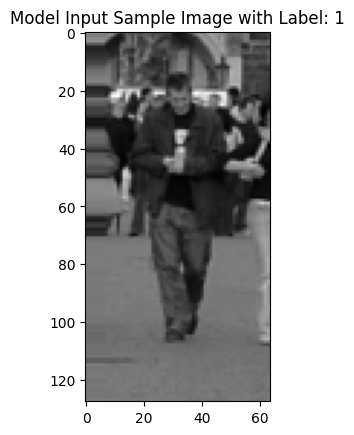

Text(0.5, 1.0, 'Test Data Sample Image with Label: 0')

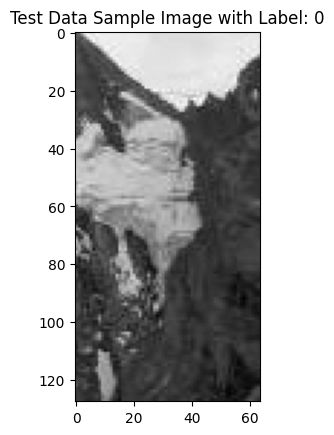

In [9]:
# Visualize a sample of model input data
sample_index = 10
sample_image = cv2.imread(glob.glob(os.path.join(pos_im_path, "*.png"))[sample_index], 0)
plt.imshow(sample_image, cmap='gray')
plt.title(f'Model Input Sample Image with Label: {labels[sample_index]}')
plt.show()

# Visualize a sample of test data
test_sample_index = 0
test_sample_image = cv2.imread(glob.glob(os.path.join(neg_im_path, "*.jpg"))[test_sample_index], 0)
plt.imshow(test_sample_image, cmap='gray')
plt.title(f'Test Data Sample Image with Label: {test_labels[test_sample_index]}')

## Exploratory data Analysis

Number of positive samples in training data: 1914 (42.3%)
Number of negative samples in training data: 2606 (57.7%)


Total data samples: 5650
Training data samples: 4520
Testing data samples: 1130


Total positive samples: 2416
Total negative samples: 3234
Number of positive samples in testing data: 502 (44%)
Number of negative samples in testing data: 628 (56%)


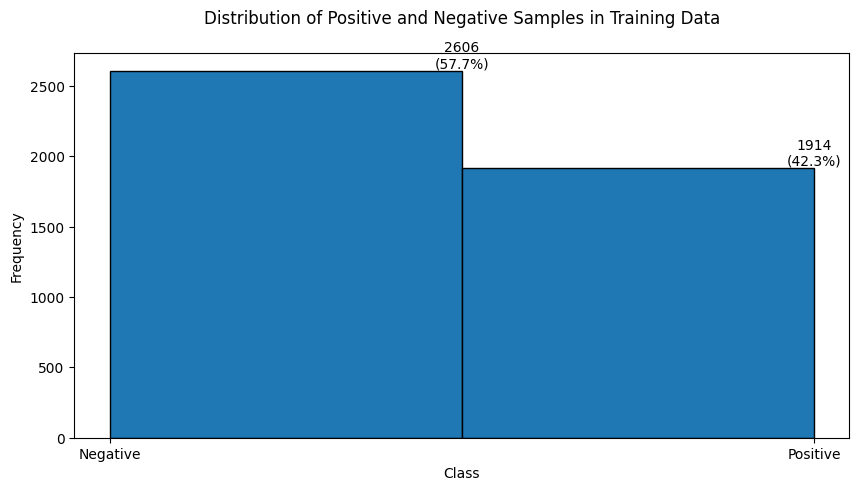

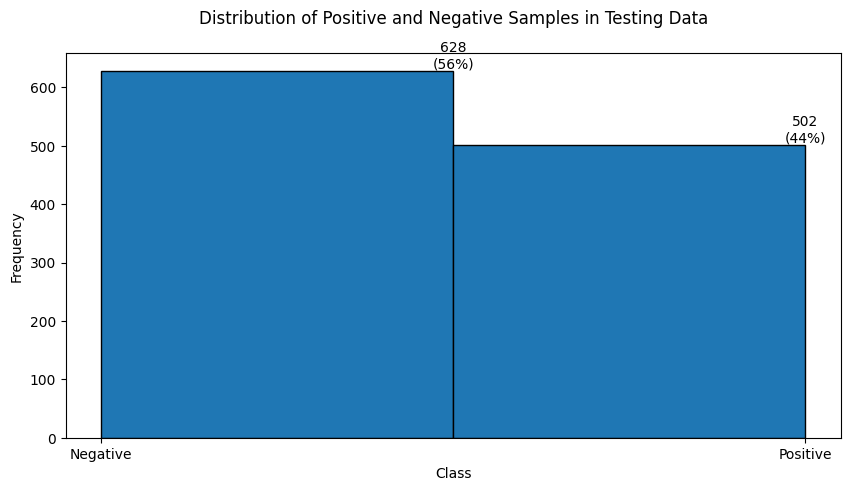

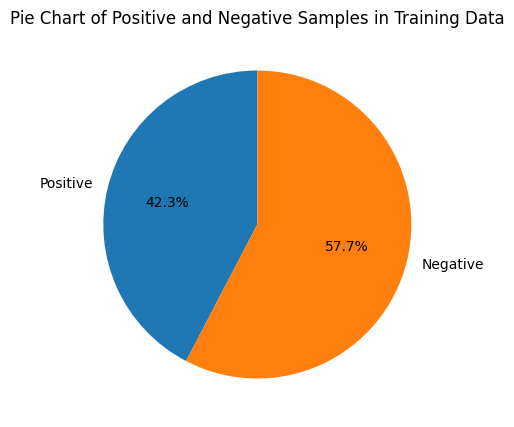

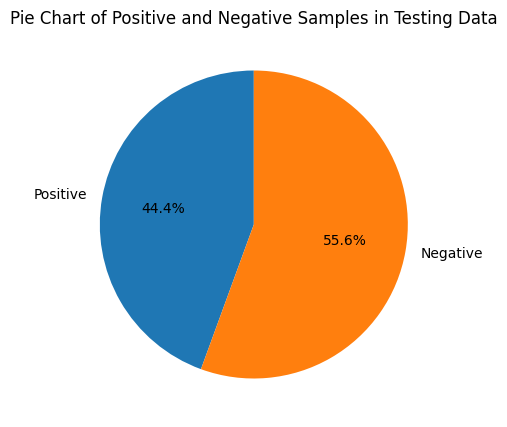

In [10]:
import matplotlib.pyplot as plt

# Visualize the distribution of positive and negative samples in training data
plt.figure(figsize=(10, 5))
counts, bins, patches = plt.hist(train_labels, bins=2, edgecolor='black')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Positive and Negative Samples in Training Data\n')

# Calculate and display the number and percentage of samples
total_train_samples = len(train_labels)
num_positive_train = sum(train_labels == 1)
num_negative_train = sum(train_labels == 0)
percent_positive_train = (num_positive_train / total_train_samples) * 100
percent_negative_train = (num_negative_train / total_train_samples) * 100

for i, count in enumerate(counts):
    percentage = (count / total_train_samples) * 100
    plt.text(bins[i] + 0.5, count, f'{int(count)}\n({percentage:.1f}%)', ha='center', va='bottom')

print(f"Number of positive samples in training data: {num_positive_train} ({percent_positive_train:.1f}%)")
print(f"Number of negative samples in training data: {num_negative_train} ({percent_negative_train:.1f}%)")

# Visualize the distribution of positive and negative samples in testing data
plt.figure(figsize=(10, 5))
counts, bins, patches = plt.hist(test_labels, bins=2, edgecolor='black')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Positive and Negative Samples in Testing Data\n')

# Calculate and display the number and percentage of samples
total_test_samples = len(test_labels)
num_positive_test = sum(test_labels == 1)
num_negative_test = sum(test_labels == 0)
percent_positive_test = (num_positive_test / total_test_samples) * 100
percent_negative_test = (num_negative_test / total_test_samples) * 100

for i, count in enumerate(counts):
    percentage = (count / total_test_samples) * 100
    plt.text(bins[i] + 0.5, count, f'{int(count)}\n({percentage:.0f}%)', ha='center', va='bottom')

# Print total data and how much for test and train
total_samples = len(labels)
print(f"\n\nTotal data samples: {total_samples}")
print(f"Training data samples: {total_train_samples}")
print(f"Testing data samples: {total_test_samples}")

# Print how much are positive and negative class
total_positive_samples = num_positive_train + num_positive_test
total_negative_samples = num_negative_train + num_negative_test
print(f"\n\nTotal positive samples: {total_positive_samples}")
print(f"Total negative samples: {total_negative_samples}")

print(f"Number of positive samples in testing data: {num_positive_test} ({percent_positive_test:.0f}%)")
print(f"Number of negative samples in testing data: {num_negative_test} ({percent_negative_test:.0f}%)")

# Pie chart for training data
plt.figure(figsize=(10, 5))
plt.pie([num_positive_train, num_negative_train], labels=['Positive', 'Negative'], autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart of Positive and Negative Samples in Training Data')
plt.show()

# Pie chart for testing data
plt.figure(figsize=(10, 5))
plt.pie([num_positive_test, num_negative_test], labels=['Positive', 'Negative'], autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart of Positive and Negative Samples in Testing Data')
plt.show()

In [16]:
import pandas as pd

# Convert the first training data sample to a pandas DataFrame for visualization
df_train_data_sample = pd.DataFrame(train_data[0])
df_train_data_sample.columns = ['HOG Feature Value']

# Add the label to the DataFrame
df_train_data_sample['Label'] = train_labels[0]
df_train_data_sample['Label'].value_counts()

Label
1    6804
Name: count, dtype: int64

## Train the model

Iteration 1, Hinge Loss: 0.582690907592287, Accuracy: 1.0
Iteration 2, Hinge Loss: 0.5826906170788659, Accuracy: 1.0
Iteration 3, Hinge Loss: 0.5826904498339023, Accuracy: 1.0
Iteration 4, Hinge Loss: 0.5826887273750215, Accuracy: 1.0
Iteration 5, Hinge Loss: 0.5826900701689579, Accuracy: 1.0
Iteration 6, Hinge Loss: 0.5826908386753312, Accuracy: 1.0
Iteration 7, Hinge Loss: 0.5826897919271747, Accuracy: 1.0
Iteration 8, Hinge Loss: 0.5826899056322717, Accuracy: 1.0
Iteration 9, Hinge Loss: 0.5826894859735834, Accuracy: 1.0
Iteration 10, Hinge Loss: 0.5826907680496025, Accuracy: 1.0
Model saved: models/models.dat


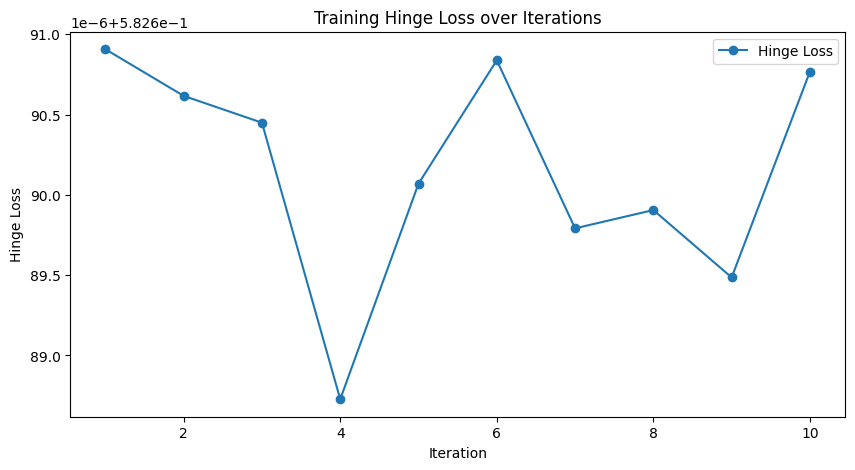

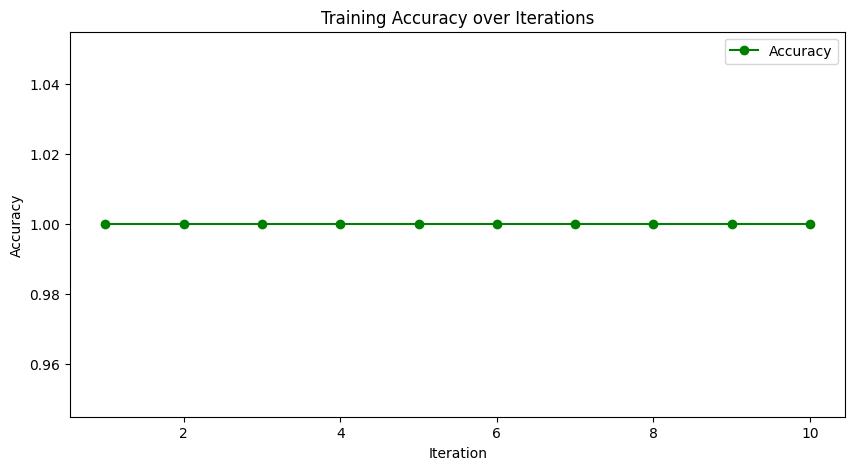

In [32]:
model = LinearSVC(max_iter=10000)  # Increase the number of iterations to ensure convergence


# Fit the model and visualize the training process
hinge_losses = []
accuracies = []
for i in range(1, 11):
    model.fit(train_data, train_labels)
    # Calculate the hinge loss manually
    decision_function = model.decision_function(train_data)
    hinge_loss = np.mean(np.maximum(0, 1 - train_labels * decision_function))
    hinge_losses.append(hinge_loss)
    
    # Calculate accuracy
    predictions = model.predict(train_data)
    accuracy = accuracy_score(train_labels, predictions)
    accuracies.append(accuracy)
    
    print(f'Iteration {i}, Hinge Loss: {hinge_loss}, Accuracy: {accuracy}')


# Save the trained model
joblib.dump(model, model_path)
print('Model saved:', model_path)


# Plot the hinge loss over iterations
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), hinge_losses, marker='o', label='Hinge Loss')
plt.xlabel('Iteration')
plt.ylabel('Hinge Loss')
plt.title('Training Hinge Loss over Iterations')
plt.legend()
plt.show()

# Plot the accuracy over iterations
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), accuracies, marker='o', label='Accuracy', color='green')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Iterations')
plt.legend()
plt.show()

## Testing


In [30]:
# Load the trained model
model = joblib.load(model_path)
print('Model loaded:', model_path)


Model loaded: models/models.dat


Test Accuracy: 0.9221238938053097
Test Precision: 0.9090909090909091
Test Recall: 0.9163346613545816
Test F1 Score: 0.9126984126984127


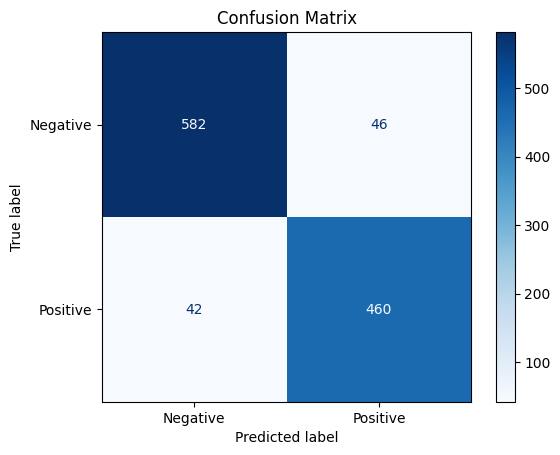

In [33]:
# Evaluate model performance on test data
test_predictions = model.predict(test_data)
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')

# Plot the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Person Detection

Load an image, apply the sliding window and pyramid technique, and use the trained SVM model to detect persons.

In [45]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color, exposure

# Load the image from the specified path
image_path = 'test/bolt.jpg'
image = cv2.imread(image_path)
cv2.imshow('Loaded Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Resize the image to a fixed size for consistency
resized_image = cv2.resize(image, (400, 256))
print("Resized image shape:", resized_image.shape)

cv2.imshow('Resized image', resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Convert the resized image to grayscale
gray_image = color.rgb2gray(resized_image)
print("Grayscale image shape:", gray_image.shape)

cv2.imshow('Grayscale image', gray_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Resized image shape: (256, 400, 3)
Grayscale image shape: (256, 400)


In [102]:
from PIL import Image, ImageDraw
import imageio

def create_gif(images, gif_path, duration=500, loop=0):
    # Save the GIF
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=duration, loop=loop)

# Load and preprocess the image
image = cv2.imread('test/test.jpg')
image = cv2.resize(image, (400, 256))
size = (64, 128)
step_size = (9, 9)
downscale = 1.25

# List to store detections
detections = []

# Load the trained model
model = joblib.load(model_path)

# Initialize scale
scale = 0

# List to store images for GIF
gif_images = []

# Apply sliding window and pyramid
# Loop over each layer of the image pyramid
for im_scaled in pyramid_gaussian(image, downscale=downscale):
    
    # Convert the scaled image to uint8 if it is float
    im_scaled_uint8 = (im_scaled * 255).astype(np.uint8) if im_scaled.dtype == np.float64 else im_scaled
    # Convert the image to RGB format for saving as GIF
    im_scaled_rgb = cv2.cvtColor(im_scaled_uint8, cv2.COLOR_BGR2RGB) if len(im_scaled_uint8.shape) == 3 else im_scaled_uint8
    # Append the image to the list for GIF
    gif_images.append(Image.fromarray(im_scaled_rgb))
    
    # Save the current layer of the pyramid as an image
    layer_image_path = f'pyramid_layer_{scale}.png'
    imageio.imwrite(layer_image_path, im_scaled_rgb)
    
    # If the scaled image is smaller than the window size, stop the loop
    if im_scaled.shape[0] < size[1] or im_scaled.shape[1] < size[0]:
        break
    # Loop over each window in the current layer of the image pyramid
    for (x, y, window) in sliding_window(im_scaled, size, step_size):
        # If the window size does not match the desired size, skip this window
        if window.shape[0] != size[1] or window.shape[1] != size[0]:
            continue
        # Convert the window to grayscale
        window = color.rgb2gray(window)
        # Compute HOG features for the window
        fd = hog(window, orientations=9, pixels_per_cell=(8, 8), visualize=False, cells_per_block=(3, 3))
        # Reshape the feature descriptor to match the model input
        fd = fd.reshape(1, -1)
        # Predict using the trained model
        pred = model.predict(fd)
        
        # If the prediction is positive and the decision function score is greater than 0.5
        if pred == 1 and model.decision_function(fd) > 0.5:
            print(pred)
            # Append the detection to the list with scaled coordinates and size
            detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fd), 
                               int(size[0] * (downscale**scale)), int(size[1] * (downscale**scale))))
            # Visualize the detection process step by step
            clone = im_scaled.copy()
            cv2.rectangle(clone, (x, y), (x + size[0], y + size[1]), (0, 255, 0), 2)  # Green bounding box
            # To change the color of the bounding box, modify the (0, 255, 0) tuple to the desired BGR color
            # For example, (255, 0, 0) for blue, (0, 0, 255) for red, etc.
            # Convert the clone image to uint8 if it is float
            clone_uint8 = (clone * 255).astype(np.uint8) if clone.dtype == np.float64 else clone
            # Convert the image to RGB format for saving as GIF
            clone_rgb = cv2.cvtColor(clone_uint8, cv2.COLOR_BGR2RGB) if len(clone_uint8.shape) == 3 else clone_uint8
            gif_images.append(Image.fromarray(clone_rgb))
            # Visualize the detection process step by step in the Gaussian pyramid
            pyramid_clone = im_scaled.copy()
            cv2.rectangle(pyramid_clone, (x, y), (x + size[0], y + size[1]), (0, 255, 0), 2)  # Green bounding box
            pyramid_clone_uint8 = (pyramid_clone * 255).astype(np.uint8) if pyramid_clone.dtype == np.float64 else pyramid_clone
            pyramid_clone_rgb = cv2.cvtColor(pyramid_clone_uint8, cv2.COLOR_BGR2RGB) if len(pyramid_clone_uint8.shape) == 3 else pyramid_clone_uint8
            gif_images.append(Image.fromarray(pyramid_clone_rgb))
    # Increment the scale for the next layer of the image pyramid
    scale += 1

# Create the GIF
gif_path = 'gaussian_pyramid.gif'
create_gif(gif_images, gif_path, duration=300, loop=0)  # Set loop to 0 to stop the GIF at the end


# Close all OpenCV windows
cv2.destroyAllWindows()

[1]
[1]
[1]


## Visualizing Detections

Use non-max suppression to filter overlapping bounding boxes and visualize the final detections.

In [25]:
detections

[(81, 108, array([2.20504637]), 64, 128),
 (135, 90, array([0.8962923]), 80, 160),
 (196, 14, array([1.3707157]), 100, 200)]

In [26]:
detections
rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])
rects

array([[ 81, 108, 145, 236],
       [135,  90, 215, 250],
       [196,  14, 296, 214]])

In [27]:
rects = np.array([[max(0, x), max(0, y), min(image.shape[1], x + w), min(image.shape[0], y + h)] for (x, y, _, w, h) in detections])
rects


array([[ 81, 108, 145, 236],
       [135,  90, 215, 250],
       [196,  14, 296, 214]])

In [28]:
sc = [score[0] for (x, y, score, w, h) in detections]
sc
sc = np.array(sc)
sc

array([2.20504637, 0.8962923 , 1.3707157 ])

In [29]:
# Apply non-max suppression
pick = non_max_suppression(rects, probs=sc, overlapThresh=0.3)
pick


array([[ 81, 108, 145, 236],
       [196,  14, 296, 214],
       [135,  90, 215, 250]])

In [30]:
# Copy the original image
clone = image.copy()

# Convert detections to numpy array
rects = np.array([[max(0, x), max(0, y), min(image.shape[1], x + w), min(image.shape[0], y + h)] for (x, y, _, w, h) in detections])
sc = [score[0] for (x, y, score, w, h) in detections]
sc = np.array(sc)

# Apply non-max suppression
pick = non_max_suppression(rects, probs=sc, overlapThresh=0.3)

# Draw rectangles on the image
for (x1, y1, x2, y2) in pick:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(clone, 'human', (x1-2, y1-2), 1, 0.75, (121, 12, 34), 1)

# Display the result
cv2.imshow('human Detection', clone)
cv2.waitKey(0)
cv2.destroyAllWindows()

---

In [32]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

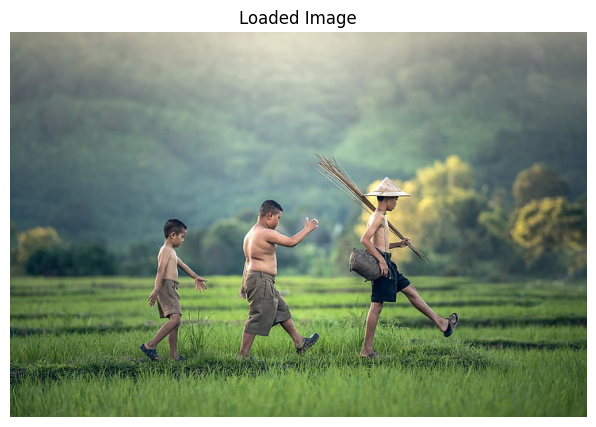

image shape: (486, 728, 3)


In [97]:
# Load the image from the specified path
image_path = 'test/test.jpg'
image = cv2.imread(image_path)

# Plot the loaded image
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Loaded Image')
plt.axis('off')
plt.show()

print("image shape:", image.shape)

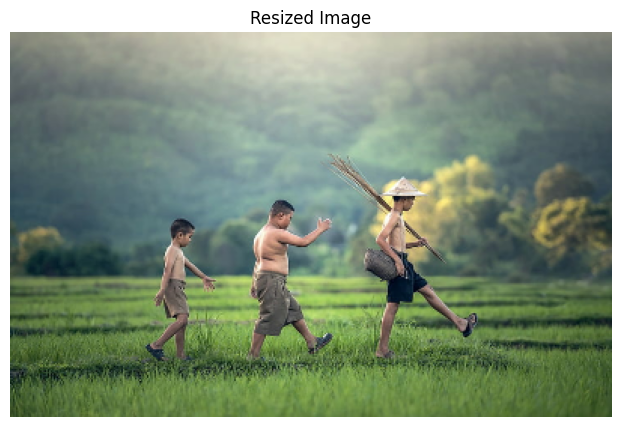

Resized image shape: (256, 400, 3)


In [98]:
# Resize the image to a fixed size for consistency
resized_image = cv2.resize(image, (400, 256))


# Plot the resized image
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title('Resized Image')
plt.axis('off')
plt.show()

print("Resized image shape:", resized_image.shape)

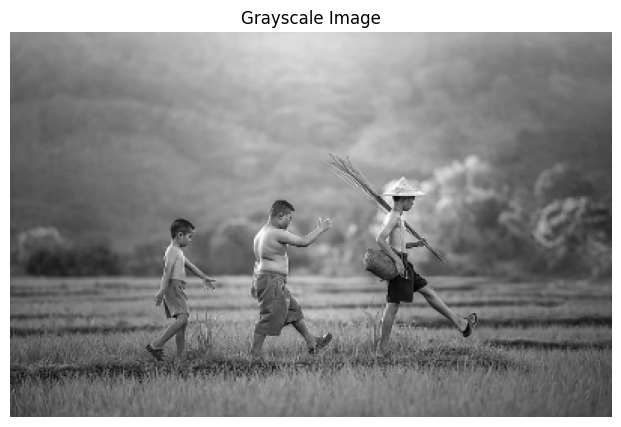

Grayscale image shape: (256, 400)


In [108]:
# Convert the resized image to grayscale
gray_image = color.rgb2gray(resized_image)

# Save the grayscale image in the current directory
cv2.imwrite('grayscale_image.jpg', (gray_image * 255).astype(np.uint8))

# Plot the grayscale image
plt.figure(figsize=(10, 5))
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

print("Grayscale image shape:", gray_image.shape)


In [109]:
# Compute HOG features and HOG image
hog_features, hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

hog_image_shape = hog_image.shape 
hog_features_shape = hog_features.shape

print("HOG image shape:", hog_image_shape)
print("HOG features shape:", hog_features_shape)


HOG image shape: (256, 400)
HOG features shape: (54684,)


((256, 400), (54684,))

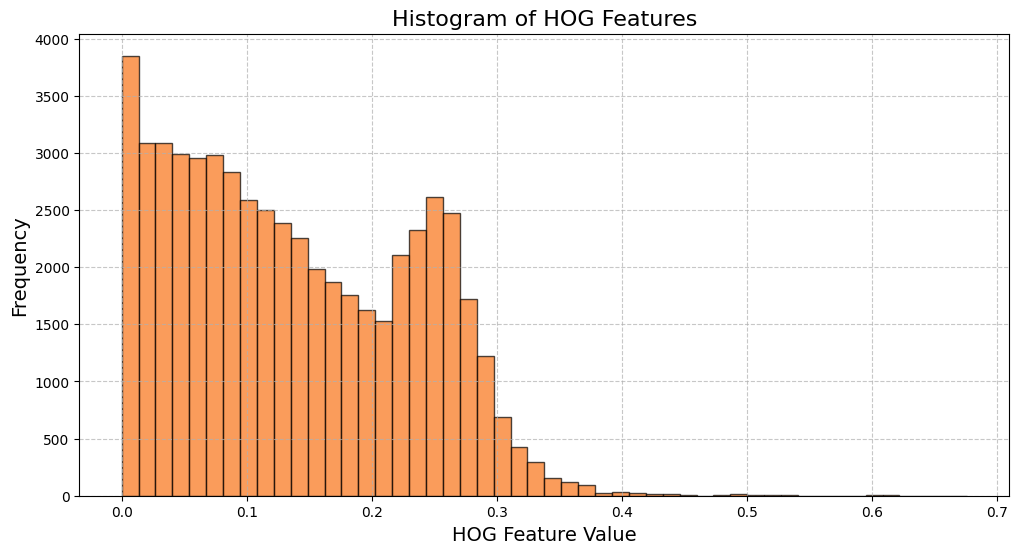

In [113]:
# Plot the histogram of HOG features
plt.figure(figsize=(12, 6))
plt.hist(hog_features, bins=50, color='#F97316', alpha=0.7, edgecolor='black')
plt.title('Histogram of HOG Features', fontsize=16)
plt.xlabel('HOG Feature Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('hog_features_histogram.png')
plt.show()


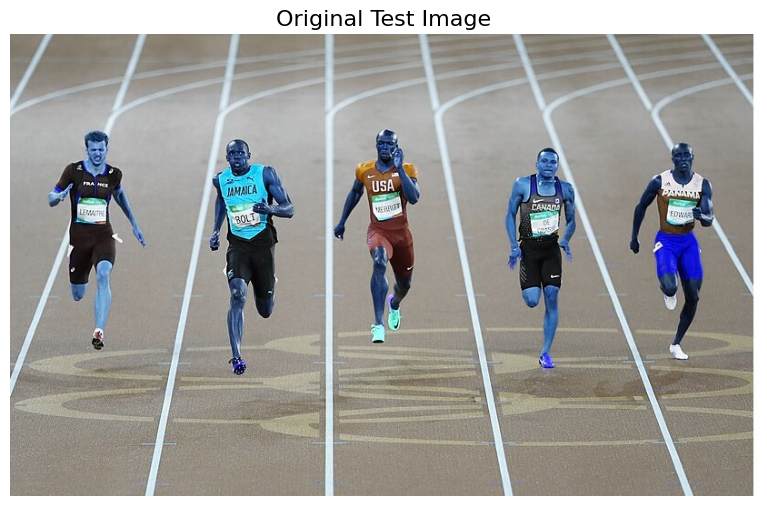

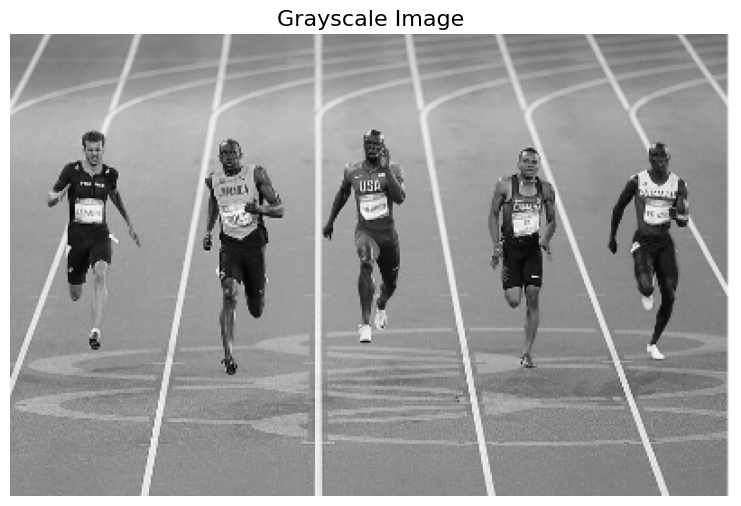

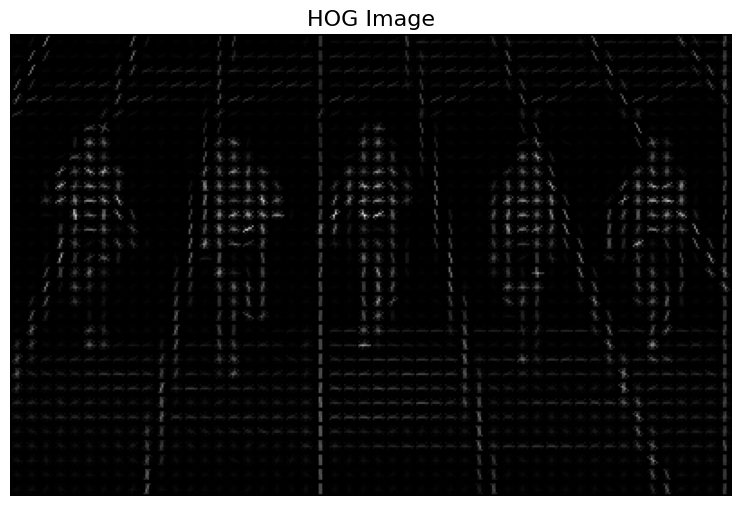

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


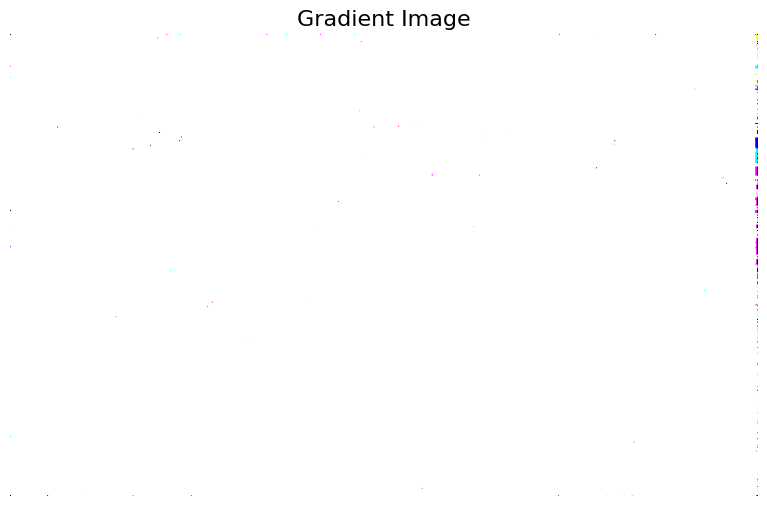

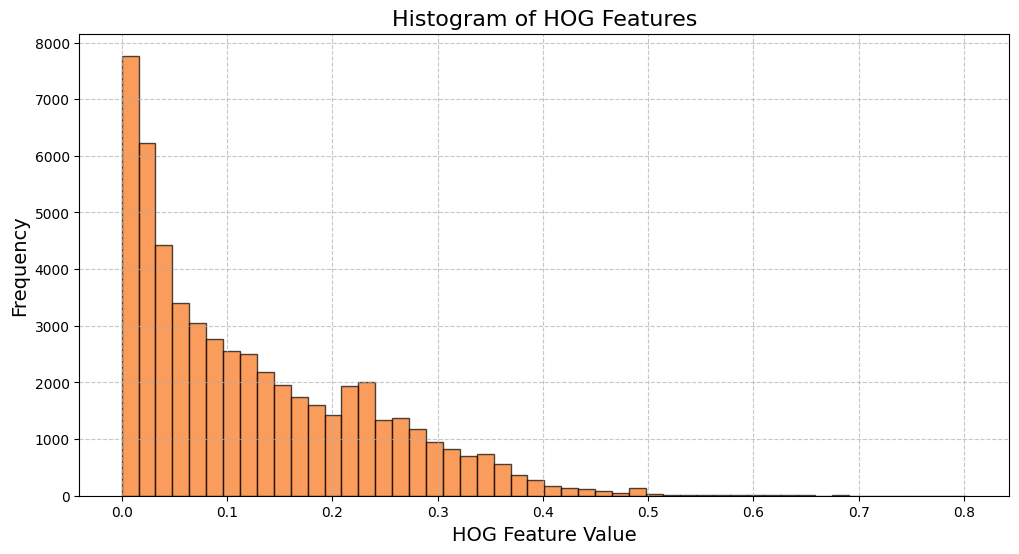

In [88]:
# Plot the original test image
plt.figure(figsize=(12, 6))
plt.imshow(np.clip(test_image, 0, 255))
plt.title('Original Test Image', fontsize=16)
plt.axis('off')
plt.show()

# Plot the grayscale image
plt.figure(figsize=(12, 6))
plt.imshow(np.clip(gray_image, 0, 255), cmap='gray')
plt.title('Grayscale Image', fontsize=16)
plt.axis('off')
plt.show()

# Plot the HOG image
plt.figure(figsize=(12, 6))
plt.imshow(np.clip(hog_image, 0, 255), cmap='gray')
plt.title('HOG Image', fontsize=16)
plt.axis('off')
plt.show()

# Compute gradient image
gradient_x = cv2.Sobel(test_image, cv2.CV_64F, 1, 0, ksize=5)
gradient_y = cv2.Sobel(test_image, cv2.CV_64F, 0, 1, ksize=5)
gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)

# Plot the gradient image
plt.figure(figsize=(12, 6))
plt.imshow(np.clip(gradient_magnitude, 0, 255), cmap='gray')
plt.title('Gradient Image', fontsize=16)
plt.axis('off')
plt.show()

# Plot the histogram of HOG features
plt.figure(figsize=(12, 6))
plt.hist(hog_features, bins=50, color='#F97316', alpha=0.7, edgecolor='black')
plt.title('Histogram of HOG Features', fontsize=16)
plt.xlabel('HOG Feature Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
